In [23]:
import numpy as np

In [24]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
from sklearn.model_selection import GridSearchCV

In [41]:
# Path to the directory containing your dataset
directory_path = r'C:\Users\AFO\Documents\har70plus'

# Initialize an empty DataFrame to combine all data
combined_data = pd.DataFrame()

# Loop through all CSV files in the directory
for file_name in os.listdir(directory_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(directory_path, file_name)
        temp_data = pd.read_csv(file_path)
        combined_data = pd.concat([combined_data, temp_data], ignore_index=True)

# Check for missing values in the combined dataset
missing_values = combined_data.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64


In [42]:
# Display total number of missing values
total_missing = combined_data.isnull().sum().sum()
print("\nTotal missing values:", total_missing)


Total missing values: 0


In [28]:
# Map labels to activities
label_mapping = {
    1: "Sitting",
    3: "Standing",
    6: "Walking",
    7: "Running",
    8: "Lying Down"
}
combined_data['activity'] = combined_data['label'].map(label_mapping)

In [29]:
# Remove rows with "Standing" activity
combined_data_filtered = combined_data[combined_data['activity'] != 'Standing']


In [30]:
# Define features and target
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X = combined_data_filtered[sensor_columns]
y = combined_data_filtered['activity']
print(combined_data_filtered['activity'].value_counts())
print(combined_data['label'].unique())

Sitting       407922
Walking       163109
Running       157244
Lying Down     77838
Name: activity, dtype: int64
[6 3 1 7 8 5 4]


In [31]:
# After mapping labels
print("Original label distribution:")
print(combined_data['label'].value_counts())

print("\nActivity distribution after mapping:")
print(combined_data['activity'].value_counts())

# Verify the mapping worked correctly
print("\nSample rows with original labels and mapped activities:")
print(combined_data[['label', 'activity']].head(10))

Original label distribution:
1    407922
6    163109
7    157244
8     77838
3     23902
5      1532
4       696
Name: label, dtype: int64

Activity distribution after mapping:
Sitting       407922
Walking       163109
Running       157244
Lying Down     77838
Standing       23902
Name: activity, dtype: int64

Sample rows with original labels and mapped activities:
   label activity
0      6  Walking
1      6  Walking
2      6  Walking
3      6  Walking
4      6  Walking
5      6  Walking
6      6  Walking
7      6  Walking
8      6  Walking
9      6  Walking


In [32]:
# Convert y to categorical
y = y.astype('category')

# Remove any rows where X or y contains NaN values
X = X.dropna()
y = y.dropna()

# Align indices of X and y to ensure they match
X = X.loc[y.index]
y = y.loc[X.index]

# Check again for any NaN values
print("Missing values in X:", X.isnull().sum().sum())
print("Missing values in y:", y.isnull().sum())

Missing values in X: 0
Missing values in y: 0


In [33]:
# Convert X to numeric 
X = X.apply(pd.to_numeric, errors='coerce')

# Verify data types
print("Data types of X:\n", X.dtypes)
print("Data type of y:", y.dtypes)

Data types of X:
 back_x     float64
back_y     float64
back_z     float64
thigh_x    float64
thigh_y    float64
thigh_z    float64
dtype: object
Data type of y: category


In [34]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the split
print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 644890
Test set size: 161223


In [35]:
# Sample a small subset for feature selection
sample_fraction = 0.01
X_sampled = X_train.sample(frac=sample_fraction, random_state=42)
y_sampled = y_train.loc[X_sampled.index]

# Select top k features
selector = SelectKBest(score_func=f_classif, k=4)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

In [36]:
# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=10, max_depth=10, class_weight='balanced', random_state=42)
rf_model.fit(X_train_reduced, y_train)

# Predictions on the test set
y_pred = rf_model.predict(X_test_reduced)

# Evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9351395272386694

Classification Report:
               precision    recall  f1-score   support

  Lying Down       1.00      1.00      1.00     15568
     Running       1.00      1.00      1.00     31449
     Sitting       0.98      0.89      0.93     81584
     Walking       0.78      0.96      0.86     32622

    accuracy                           0.94    161223
   macro avg       0.94      0.96      0.95    161223
weighted avg       0.94      0.94      0.94    161223


In [40]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10],
    'max_depth': [4],
    'random_state': [0],
    'max_features': ['sqrt']
}

# Use GridSearchCV for exhaustive search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=2,  # Reduce the number of folds
    scoring='accuracy',
    verbose=2,
    n_jobs=1  # Use a single processor to avoid resource contention
)

# Fit the grid search on the downsampled data
grid_search.fit(X_sampled, y_sampled)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END max_depth=4, max_features=sqrt, n_estimators=10, random_state=0; total time=   0.0s
[CV] END max_depth=4, max_features=sqrt, n_estimators=10, random_state=0; total time=   0.0s
Best Parameters: {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10, 'random_state': 0}
Best Score: 0.9302214976821128


In [45]:
#Final Model with Best Parameters
final_rf = RandomForestClassifier(**grid_search.best_params_, class_weight='balanced')
final_rf.fit(X_train_reduced, y_train)
final_y_pred = final_rf.predict(X_test_reduced)

In [46]:
print("Final Accuracy:", accuracy_score(y_test, final_y_pred))
print("\nFinal Classification Report:\n", classification_report(y_test, final_y_pred))

Final Accuracy: 0.8398367478585561

Final Classification Report:
               precision    recall  f1-score   support

  Lying Down       1.00      1.00      1.00     15568
     Running       1.00      1.00      1.00     31449
     Sitting       0.97      0.70      0.82     81584
     Walking       0.56      0.95      0.71     32622

    accuracy                           0.84    161223
   macro avg       0.88      0.91      0.88    161223
weighted avg       0.90      0.84      0.85    161223


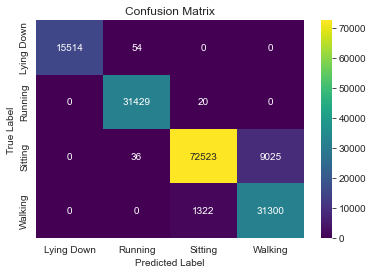

In [47]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=y_test.cat.categories, yticklabels=y_test.cat.categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()